First we instantiate the simulator class we will use to generate our sequences. The Simulator handles all the particulars about the target being tracked. This simulation in particular is a Linear Time Invariant scenario of an object travelling at a constant velocity in two dimensions. However, it is being observed via a nonlinear measurement model.

In particular it is a Bearing Range sensor positioned at the origin of the coordinate system. Measurements are collected as a 2 dimensional vector containing an angle, and a distance.

In [1]:
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState
from stonesoup.types.detection import Detection

from stonesoup.types.track import Track
from stonesoup.types.hypothesis import SingleHypothesis

class simulator():

    def __init__(self, transition_model, measurement_model, state_range, meas_range = None, noise_range = None, meas_noise_range = None):
        """
        Parameters
        ----------
        transition_model : :class:`~.Predictor`
            The Stone Soup predictor to be used.
        measurement_model : :class:`~.Predictor`
            The Updater to be used.
        """
        self.transition_model= transition_model
        self.measurement_model = measurement_model
        self.state_range = state_range
        self.meas_range = meas_range
        self.noise_range = noise_range
        self.meas_noise_range = meas_noise_range

    def _generate_ground_truth(self, prior, time_span):
        
        time_interval = time_span[1]-time_span[0]
        ground_truth = GroundTruthPath([prior])
        for k in range(1, len(time_span)):
            ground_truth.append(GroundTruthState(
                self.transition_model.function(ground_truth[k-1], noise=True, time_interval=time_interval),
                timestamp=time_span[k-1]))
        return ground_truth
    
    def _simulate_measurements(self, ground_truth):
        #Simulate Measurements
        measurements = []
        for state in ground_truth:
            measurement = self.measurement_model.function(state, noise=True)
            measurements.append(Detection(measurement,
                                          timestamp=state.timestamp,
                                          measurement_model=self.measurement_model))
        return measurements

    def _initializer(self, time_stamp):
        state_range_min = self.state_range[0]
        state_range_max = self.state_range[1]
        state_vector = StateVector(np.random.uniform(low=state_range_min, high=state_range_max))
        while np.sqrt(state_vector[1]**2+state_vector[3]**2) < 0.15:
            state_vector = StateVector(np.random.uniform(low=state_range_min, high=state_range_max))
        meas_range_low = self.meas_range[0]
        meas_range_max = self.meas_range[1]
        self.measurement_model.translation_offset = np.random.uniform(low=meas_range_low, high=meas_range_max).reshape(len(meas_range_low),1)
        #process_noise = 
        #self.transition_model. = np.randint(low=0,high=len(noise_range))
        
        return State(state_vector = state_vector, timestamp=time_stamp)

    def generate_training_data(self, time_span):
        """

        Parameters
        ----------
        ground_truth : :class:`~.GroundTruthPath`
            StateMutableSequence type object used to store ground truth.
        initial_state : :class:`~.State`
            Initial state for the ground truth system. This MUST be a State,
            not a State subclass, like GaussianState or EnsembleState.
        prior : :class:`~.GaussianState` or :class:`~.EnsembleState`
            Initial state prediction of tracking algorithm.

        Returns
        -------
        track : :class:`~.Track`
            The Stone Soup track object which contains the list of updated 
            state predictions made by the tracking algorithm employed.
        """

        #Simulate Measurements
        initial_state = self._initializer(time_span[0])
        ground_truth = self._generate_ground_truth(initial_state, time_span)
        measurements = self._simulate_measurements(ground_truth)
        
        return ground_truth, measurements

    def simulate_track(self, predictor, updater, initial_state, prior, time_span):
        """

        Parameters
        ----------
        predictor : :class:`~.Predictor`
            The Stone Soup predictor to be used.
        updater : :class:`~.Predictor`
            The Updater to be used.
        ground_truth : :class:`~.GroundTruthPath`
            StateMutableSequence type object used to store ground truth.
        initial_state : :class:`~.State`
            Initial state for the ground truth system. This MUST be a State,
            not a State subclass, like GaussianState or EnsembleState.
        prior : :class:`~.GaussianState` or :class:`~.EnsembleState`
            Initial state prediction of tracking algorithm.

        Returns
        -------
        track : :class:`~.Track`
            The Stone Soup track object which contains the list of updated 
            state predictions made by the tracking algorithm employed.
        """

        #Simulate Measurements
        ground_truth = self._generate_ground_truth(initial_state, time_span)
        measurements = self._simulate_measurements(ground_truth)
        
        #Initialize Loop Variables
        track = Track()
        for measurement in measurements:
            prediction = predictor.predict(prior, timestamp=measurement.timestamp)
            hypothesis = SingleHypothesis(prediction, measurement)  # Group a prediction and measurement
            posterior = updater.update(hypothesis)
            track.append(posterior)
            prior = track[-1]
        return ground_truth, track

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import datetime

from stonesoup.types.array import StateVector, CovarianceMatrix
from stonesoup.types.state import State, GaussianState

from stonesoup.models.transition.linear import (CombinedLinearGaussianTransitionModel,
                                                ConstantVelocity)
from stonesoup.models.measurement.linear import LinearGaussian
from stonesoup.updater.kalman import KalmanUpdater, ExtendedKalmanUpdater
from stonesoup.predictor.ensemble import EnsemblePredictor
from stonesoup.predictor.kalman import KalmanPredictor, ExtendedKalmanPredictor
from stonesoup.models.measurement.nonlinear import CartesianToBearingRange

"""
    This script represents the code used to gather the data used in [PAPER HERE].
    
    This repository is structured such that different stone soup algorithms 
    can be run rapidly. Hopefully I've made it modular enough to 
    allow swapping of things like algorithms, and "experiments" by replacing
    the desired transition and measurement models.
    
    The simulator class requires a transition and 
    measurement model, then the simulate_track method accepts a Stone Soup
    Predictor, Updater, ground truth initial state, initial state for the
    chosen algorithm, and a span of time which the simulation takes place over.
    This time span should be an evenly spaced datetime.datetime list.
    
    The simulator then, is used to gather "Track" instances, and with a list 
    of tracks, RMSE can then be calculated.
"""

i = 60
num_vectors = i*5

"""
    Here, we get our initial variables for simulation. For this, we are just
    using a time span of 60 time instances spaced one second apart.
"""

timestamp = datetime.datetime(2021, 4, 2, 12, 28, 57)
tMax = 30
dt = 1
tRange = tMax // dt
plot_time_span = np.array([dt*i for i in range(tRange)])

time_span = np.array([timestamp + datetime.timedelta(seconds=dt*i) for i in range(tRange)])

"""
Here we instantiate our transition and measurement models. These are the 
same models used in the StoneSoup Kalman Filter examples.
"""

q_x = 0.05
q_y = 0.05
sensor_x = 0  # Placing the sensor off-centre
sensor_y = 0

transition_model = CombinedLinearGaussianTransitionModel([ConstantVelocity(q_x),
                                                          ConstantVelocity(q_y)])

measurement_model = CartesianToBearingRange(
ndim_state=4,
mapping=(0, 2),
noise_covar=np.diag([np.radians(1)**2, 0.1**2]),  # Covariance matrix. 0.2 degree variance in
# bearing and 1 metre in range
translation_offset=np.array([[sensor_x], [sensor_y]])  # Offset measurements to location of
# sensor in cartesian.
)


In order to use this simulated data, we need to format it such that it can be loaded into PyTorch easily. Pytorch requires us to specify functions "__get_item__" and "__len__" in order to be usable by the generic Data Loader. I simply included the init and a helper function to append trajectories to the dataset for ease of use.

In [3]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np

# Datasets should be specified on a per simulation basis

#class sequence_generator(Dataset):

class dataset_2D_bearing_range(Dataset):
    #Range Bearing 2D Dataset Sequence Packer

    def __init__(self, dataset, ground_truth=None, measurements=None):
        if dataset == None:   
            gt = np.array([e.state_vector for e in ground_truth]).squeeze().T
            gt = torch.tensor(gt.astype(dtype=np.float32),device = device)
            ms = np.array([m.state_vector for m in measurements]).squeeze().T
            ms = torch.tensor(ms.astype(dtype=np.float32),device = device)
            self.dataset = torch.unsqueeze(torch.cat((ms,gt)),dim=0)
        else:
            self.dataset = dataset
            
    
    def append_to_dataset(self, ground_truth, measurements):
        """
        Parameters
        ----------
        ground_truth : :class:`~.list`
            A list of Stonesoup States.
        measurements : :class:`~.measurements`
            The list of Stonesoup Measurements to be used.
        """
    
        gt = np.array([e.state_vector for e in ground_truth]).squeeze().T
        gt = torch.tensor(gt.astype(dtype=np.float32),device = device)
        ms = np.array([m.state_vector for m in measurements]).squeeze().T
        ms = torch.tensor(ms.astype(dtype=np.float32),device = device)
        new_entry = torch.cat((ms,gt),dim=0)

        self.dataset = torch.cat((self.dataset,torch.unsqueeze(new_entry,dim=0)),dim=0)

    def __getitem__(self, idx):
        return self.dataset[idx,0:2].T, self.dataset[idx,2:6].T

    def __len__(self):
        return self.dataset.shape[0]



This next module is something I call the Composer. The Composer's job is to return a useful dataset for use in PyTorch, and I will tell it how many trajectories I want, and it will call the relevant simulator and dataset methods to generate a dataset for the purpose of learning.

In [4]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np

# Datasets should be specified on a per simulation basis
# Should look up realistic values for radar precision and initial states
# Come up with realistic constraints for initial velocities

#class sequence_generator(Dataset):

class dataset_composer():
    #Range Bearing 2D Dataset Sequence Packer
    def __init__(self, simulators, training_dataset, testing_dataset, batch_size, num_workers):
        #pass a list of simulators
        self.simulators = simulators
        self.training_dataset = training_dataset
        self.testing_dataset = testing_dataset
        self.batch_size = batch_size
        self.num_workers = num_workers

    def simulate_trajectories(self, training_dataset_len, testing_ratio):
        for simulator in self.simulators:
            trainset_length = int((training_dataset_len-1) / len(self.simulators)) # Partition dataset into sets from each simulator
            for i in range(trainset_length):
                ground_truth, measurements = simulator.generate_training_data(time_span)
                self.training_dataset.append_to_dataset(ground_truth, measurements)
            trainloader = DataLoader(self.training_dataset)

            testset_length = int(((training_dataset_len)*testing_ratio -1)/len(self.simulators))
            for i in range(testset_length):
                ground_truth, measurements = simulator.generate_training_data(time_span)
                self.testing_dataset.append_to_dataset(ground_truth, measurements)
            testloader = DataLoader(self.testing_dataset)
        return trainloader, testloader

    def output_to_file(self, trainset_name, testset_name):
        torch.save(self.training_dataset, trainset_name)
        torch.save(self.testing_dataset, testset_name)

    def read_from_file(self, training_file_name, testing_file_name, device):
        trn = torch.load(training_file_name, map_location = device)
        tst = torch.load(testing_file_name, map_location = device)
        return DataLoader(trn, batch_size = self.batch_size, num_workers=self.num_workers), DataLoader(tst, batch_size = self.batch_size, num_workers=self.num_workers)




Here we instantiate the simulator, provide a range of permissable values for the initial conditions, noise coefficients, and specify the transition model, and measurement model.



In [5]:
# Position, Velocity, Position, Velocity
state_range_min = np.array([-15, -2, -15, -2])
state_range_max = np.array([15, 2, 15, 2])

# Add some sort of miniumum speed

meas_range_min = np.array([0, 0])
meas_range_max = np.array([0, 0])

# Randomization for process noise
#process_noise_coefficients = [0.005, 0.05, 0.5]
process_noise_coefficients = [0.05]

nonlinear_simulator = simulator(transition_model=transition_model,
                      measurement_model=measurement_model,
                      state_range = (state_range_min, state_range_max),
                      meas_range = (meas_range_min, meas_range_max)
)

ground_truth, measurements = nonlinear_simulator.generate_training_data(time_span)
training_dataset =  dataset_2D_bearing_range(dataset = None, ground_truth = ground_truth, measurements = measurements)
testing_dataset =  dataset_2D_bearing_range(dataset = None, ground_truth = ground_truth, measurements = measurements)

#training_dataset_len = 1000000 #  1,000,000
training_dataset_len = 100000 #  100,000
#training_dataset_len = 10000
testing_ratio = 0.15

batch_size = 128
num_workers = 0

dataset_composer = dataset_composer([nonlinear_simulator], testing_dataset, training_dataset, batch_size = batch_size, num_workers = num_workers)

trainloader, testloader = dataset_composer.simulate_trajectories(training_dataset_len, testing_ratio)
dataset_composer.output_to_file('training_data','testing_data')
#trainloader, testloader = dataset_composer.read_from_file('training_data', 'testing_data', device)
#print('Training Dataset Length:', training_dataset.__len__())
#print('Testing Dataset Length:',testing_dataset.__len__())


Turn Sequences into dataset

In [6]:
import torch.nn as nn
import torch.nn.functional as F

input_size = 2
hidden_size = 32
num_layers = 1
nonlinearity = 'relu'
output_size = 4

class UniDirectionalRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, nonlinearity, num_layers, device):
        super(UniDirectionalRNN, self).__init__()
        self.RNN = torch.nn.RNN(input_size, hidden_size, bidirectional=False, num_layers=num_layers, device=device)
        self.linear = torch.nn.Linear(hidden_size, output_size, device=device)

    def forward(self, input, RNN_hidden):
        RNN_output, RNN_hidden = self.RNN(input, RNN_hidden)
        output = self.linear(RNN_output)
        return output, RNN_hidden

class BiDirectionalRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, nonlinearity, num_layers, device):
        super(BiDirectionalRNN, self).__init__()
        self.RNN = torch.nn.RNN(input_size, hidden_size, bidirectional=True, num_layers=num_layers, device=device)
        self.linear = torch.nn.Linear(2*hidden_size, output_size, device=device)

    def forward(self, input, RNN_hidden):
        RNN_output, RNN_hidden = self.RNN(input, RNN_hidden)
        output = self.linear(RNN_output)
        return output, RNN_hidden

class BiDirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, device):
        super(BiDirectionalLSTM, self).__init__()
        self.LSTM = torch.nn.LSTM(input_size, hidden_size, bidirectional=True, num_layers=num_layers, device=device)
        self.linear = torch.nn.Linear(2*hidden_size, output_size, device=device)

    def forward(self, input, LSTM_hidden, LSTM_cell):
        LSTM_output, (LSTM_hidden, LSTM_cell) = self.LSTM(input, (LSTM_hidden, LSTM_cell))
        output = self.linear(LSTM_output)
        return output, (LSTM_hidden, LSTM_cell)

class UniDirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, device):
        super(UniDirectionalLSTM, self).__init__()
        self.LSTM = torch.nn.LSTM(input_size, hidden_size, bidirectional=False, num_layers=num_layers, device=device)
        self.linear = torch.nn.Linear(hidden_size, output_size, device=device)

    def forward(self, input, LSTM_hidden, LSTM_cell):
        LSTM_output, (LSTM_hidden, LSTM_cell) = self.LSTM(input, (LSTM_hidden, LSTM_cell))
        output = self.linear(LSTM_output)
        return output, (LSTM_hidden, LSTM_cell)

class MHATransformer(nn.Module):
    def __init__(self, input_size=2, hidden_size=16, output_size = 4, nhead=4, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, device=None):
        super(MHATransformer, self).__init__()
        self.input_layer = torch.nn.Linear(input_size, hidden_size, device=device)
        self.transformer = torch.nn.Transformer(d_model=hidden_size, nhead=nhead,
                                                num_encoder_layers=num_encoder_layers,
                                                num_decoder_layers=num_decoder_layers,
                                                dim_feedforward=dim_feedforward,
                                                batch_first=True,
                                                device=device)
        self.output_layer = torch.nn.Linear(hidden_size, output_size, device=device)

    def forward(self, input):
        hidden_input = self.input_layer(input)
        transformer_output = self.transformer(hidden_input, hidden_input)
        return self.output_layer(transformer_output)

UniRNN = UniDirectionalRNN(input_size=2, hidden_size=32, output_size=4, nonlinearity=nonlinearity, num_layers=1, device=device)
BiRNN = BiDirectionalRNN(input_size=2, hidden_size=32, output_size=4, nonlinearity=nonlinearity, num_layers=1, device=device)
UniLSTM = UniDirectionalLSTM(input_size=2, hidden_size=32, output_size=4, num_layers=1, device=device)
BiLSTM = BiDirectionalLSTM(input_size=2, hidden_size=32, output_size=4, num_layers=1, device=device)
Transformer = MHATransformer(input_size=2, hidden_size = 32, output_size = 4, nhead=16, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, device=device)

Initialize Optimizers

In [7]:
criterion = nn.MSELoss()
UniRNN_learning_rate = 0.00005;
UniRNN_weight_decay = 0.000 #L2 Regularization Factor
UniRNN_optimizer = torch.optim.Adam(UniRNN.parameters(),lr=UniRNN_learning_rate, weight_decay = UniRNN_weight_decay)

criterion = nn.MSELoss()
BiRNN_learning_rate = 0.00005;
BiRNN_weight_decay = 0.000 #L2 Regularization Factor
BiRNN_optimizer = torch.optim.Adam(BiRNN.parameters(),lr=BiRNN_learning_rate, weight_decay = BiRNN_learning_rate)

criterion = nn.MSELoss()
UniLSTM_learning_rate = 0.00005;
UniLSTM_weight_decay = 0.000 #L2 Regularization Factor
UniLSTM_optimizer = torch.optim.Adam(UniLSTM.parameters(),lr=UniLSTM_learning_rate, weight_decay = UniLSTM_weight_decay)

criterion = nn.MSELoss()
BiLSTM_learning_rate = 0.00005;
BiLSTM_weight_decay = 0.000 #L2 Regularization Factor
BiLSTM_optimizer = torch.optim.Adam(BiLSTM.parameters(),lr=BiLSTM_learning_rate, weight_decay = BiLSTM_weight_decay)

criterion = nn.MSELoss()
TransformerLearning_rate = 0.000005;
TransformerWeight_decay = 0.000 #L2 Regularization Factor
Transformer_optimizer = torch.optim.Adam(Transformer.parameters(),lr=TransformerLearning_rate, weight_decay = TransformerWeight_decay)

Define Training Function

In [8]:
n_epochs = 50

UniRNN_hidden = torch.zeros((1, tMax, hidden_size),device=device)

BiRNN_hidden = torch.zeros((2, tMax, hidden_size),device=device)

UniLSTM_hidden = torch.zeros((1, tMax, hidden_size),device=device)
UniLSTM_cell = torch.zeros((1, tMax, hidden_size),device=device)

BiLSTM_hidden = torch.zeros((2, tMax, hidden_size),device=device)
BiLSTM_cell = torch.zeros((2, tMax, hidden_size),device=device)


UniRNN_training_loss = torch.zeros(len(trainloader),device=device)
BiRNN_training_loss = torch.zeros(len(trainloader),device=device)
UniLSTM_training_loss = torch.zeros(len(trainloader),device=device)
BiLSTM_training_loss = torch.zeros(len(trainloader),device=device)
Transformer_training_loss = torch.zeros(len(trainloader),device=device)

UniRNN_testing_loss = torch.zeros(len(testloader),device=device)
BiRNN_testing_loss = torch.zeros(len(testloader),device=device)
UniLSTM_testing_loss = torch.zeros(len(testloader),device=device)
BiLSTM_testing_loss = torch.zeros(len(testloader),device=device)
Transformer_testing_loss = torch.zeros(len(testloader),device=device)

UniRNN_training_loss_epoch = torch.zeros(n_epochs,device=device)
BiRNN_training_loss_epoch = torch.zeros(n_epochs,device=device)
UniLSTM_training_loss_epoch = torch.zeros(n_epochs,device=device)
BiLSTM_training_loss_epoch = torch.zeros(n_epochs,device=device)
Transformer_training_loss_epoch = torch.zeros(n_epochs,device=device)

UniRNN_testing_loss_epoch = torch.zeros(n_epochs,device=device)
BiRNN_testing_loss_epoch = torch.zeros(n_epochs,device=device)
UniLSTM_testing_loss_epoch = torch.zeros(n_epochs,device=device)
BiLSTM_testing_loss_epoch = torch.zeros(n_epochs,device=device)
Transformer_testing_loss_epoch = torch.zeros(n_epochs,device=device)

for i in range(n_epochs):
    for j, data in enumerate(trainloader):
        inputs, labels = data
        
        UniRNN_optimizer.zero_grad()
        BiRNN_optimizer.zero_grad()
        UniLSTM_optimizer.zero_grad()
        BiLSTM_optimizer.zero_grad()
        Transformer_optimizer.zero_grad()
        
        UniRNN_outputs, UniRNN_hidden = UniRNN(inputs, UniRNN_hidden.detach())
        BiRNN_outputs, BiRNN_hidden = BiRNN(inputs, BiRNN_hidden.detach())
        UniLSTM_outputs, (UniLSTM_hidden, UniLSTM_cell) = UniLSTM(inputs, UniLSTM_hidden.detach(), UniLSTM_cell.detach())
        BiLSTM_outputs, (BiLSTM_hidden, BiLSTM_cell) = BiLSTM(inputs, BiLSTM_hidden.detach(), BiLSTM_cell.detach())
        Transformer_outputs = Transformer(inputs)
        
        UniRNN_train_loss = criterion(UniRNN_outputs, labels)
        BiRNN_train_loss = criterion(BiRNN_outputs, labels)
        UniLSTM_train_loss = criterion(UniLSTM_outputs, labels)
        BiLSTM_train_loss = criterion(BiLSTM_outputs, labels)
        Transformer_train_loss = criterion(Transformer_outputs, labels)

        UniRNN_training_loss[j] = UniRNN_train_loss
        BiRNN_training_loss[j] = BiRNN_train_loss
        UniLSTM_training_loss[j] = UniLSTM_train_loss
        BiLSTM_training_loss[j] = BiLSTM_train_loss
        Transformer_training_loss[j] = Transformer_train_loss
        
        UniRNN_train_loss.backward()
        BiRNN_train_loss.backward()
        UniLSTM_train_loss.backward()
        BiLSTM_train_loss.backward()
        Transformer_train_loss.backward()
        
        UniRNN_optimizer.step()
        BiRNN_optimizer.step()
        UniLSTM_optimizer.step()
        BiLSTM_optimizer.step()
        Transformer_optimizer.step()
        
    UniRNN_training_loss_epoch[i] = torch.mean(UniRNN_train_loss).item()
    BiRNN_training_loss_epoch[i] = torch.mean(BiRNN_train_loss).item()
    UniLSTM_training_loss_epoch[i] = torch.mean(UniLSTM_train_loss).item()
    BiLSTM_training_loss_epoch[i] = torch.mean(BiLSTM_train_loss).item()
    Transformer_training_loss_epoch[i] = torch.mean(Transformer_train_loss).item()
    
    with (torch.no_grad()):
        for j, data in enumerate(testloader):
            inputs, labels = data
            
            UniRNN_outputs, UniRNN_hidden = UniRNN(inputs, UniRNN_hidden.detach())
            BiRNN_outputs, BiRNN_hidden = BiRNN(inputs, BiRNN_hidden.detach())
            UniLSTM_outputs, (UniLSTM_hidden, UniLSTM_cell) = UniLSTM(inputs, UniLSTM_hidden.detach(), UniLSTM_cell.detach())
            BiLSTM_outputs, (BiLSTM_hidden, BiLSTM_cell) = BiLSTM(inputs, BiLSTM_hidden.detach(), BiLSTM_cell.detach())
            Transformer_outputs = Transformer(inputs)
            
            UniRNN_test_loss = criterion(UniRNN_outputs, labels)
            BiRNN_test_loss = criterion(BiRNN_outputs, labels)
            UniLSTM_test_loss = criterion(UniLSTM_outputs, labels)
            BiLSTM_test_loss = criterion(BiLSTM_outputs, labels)
            Transformer_test_loss = criterion(Transformer_outputs, labels)

            UniRNN_testing_loss[j] = UniRNN_test_loss
            BiRNN_testing_loss[j] = BiRNN_test_loss
            UniLSTM_testing_loss[j] = UniLSTM_test_loss
            BiLSTM_testing_loss[j] = BiLSTM_test_loss
            Transformer_testing_loss[j] = Transformer_test_loss
            
        UniRNN_testing_loss_epoch[i] = torch.mean(UniRNN_testing_loss).item()
        BiRNN_testing_loss_epoch[i] = torch.mean(BiRNN_testing_loss).item()
        UniLSTM_testing_loss_epoch[i] = torch.mean(UniLSTM_testing_loss).item()
        BiLSTM_testing_loss_epoch[i] = torch.mean(BiLSTM_testing_loss).item()
        Transformer_testing_loss_epoch[i] = torch.mean(Transformer_testing_loss).item()

    print("-----------------------------------------------------------------",
          "\n-----      Epoch :",i+1, "        -----",
          " Train Loss :  Test Loss -----")
    print("-----  UniDirectional RNN:   -----",
          "{:10.3f}".format(UniRNN_training_loss_epoch[i].item()) +'  :'+"{:10.3f}".format(UniRNN_testing_loss_epoch[i].item())+'  -----')
    print("-----   BiDirectional RNN:   -----",
          "{:10.3f}".format(BiRNN_training_loss_epoch[i].item()) +'  :'+"{:10.3f}".format(BiRNN_testing_loss_epoch[i].item())+'  -----')
    print("-----  UniDirectional LSTM:  -----",
          "{:10.3f}".format(UniLSTM_training_loss_epoch[i].item()) +'  :'+"{:10.3f}".format(UniLSTM_testing_loss_epoch[i].item())+'  -----')
    print("-----  BiDirectional LSTM:   -----",
          "{:10.3f}".format(BiLSTM_training_loss_epoch[i].item()) +'  :'+"{:10.3f}".format(BiLSTM_testing_loss_epoch[i].item())+'  -----')
    print("-----      Transformer:      -----",
          "{:10.3f}".format(Transformer_training_loss_epoch[i].item()) +'  :'+"{:10.3f}".format(Transformer_testing_loss_epoch[i].item())+'  -----')

C:\Users\echo4\.conda\envs\rnn\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


----------------------------------------------------------------- 
-----      Epoch : 1         -----  Train Loss :  Test Loss -----
-----  UniDirectional RNN:   -----   1208.482  :  1248.754  -----
-----   BiDirectional RNN:   -----   1207.179  :  1248.000  -----
-----  UniDirectional LSTM:  -----   1208.656  :  1250.383  -----
-----  BiDirectional LSTM:   -----   1207.493  :  1248.251  -----
-----      Transformer:      -----   1142.024  :  1179.552  -----
----------------------------------------------------------------- 
-----      Epoch : 2         -----  Train Loss :  Test Loss -----
-----  UniDirectional RNN:   -----   1197.464  :  1236.983  -----
-----   BiDirectional RNN:   -----   1193.808  :  1235.300  -----
-----  UniDirectional LSTM:  -----   1200.674  :  1242.867  -----
-----  BiDirectional LSTM:   -----   1191.125  :  1231.854  -----
-----      Transformer:      -----   1126.433  :  1168.243  -----
----------------------------------------------------------------- 
-----  

Plotting

Trajectory MSE Plot

In [9]:
trajectory_mse_func = nn.MSELoss(reduction='none')
tst = torch.load('testing_data', map_location = device)
testloader = DataLoader(tst)

UniRNN_trajectory_MSE = torch.zeros(tMax, output_size, device=device)
BiRNN_trajectory_MSE = torch.zeros(tMax, output_size, device=device)
UniLSTM_trajectory_MSE = torch.zeros(tMax, output_size, device=device)
BiLSTM_trajectory_MSE = torch.zeros(tMax, output_size, device=device)
Transformer_trajectory_MSE = torch.zeros(tMax, output_size, device=device)

with (torch.no_grad()):
    j = 0
    for j, data in enumerate(testloader):
        inputs, labels = data
        
        UniRNN_outputs, UniRNN_hidden = UniRNN(inputs, UniRNN_hidden.detach())
        BiRNN_outputs, BiRNN_hidden = BiRNN(inputs, BiRNN_hidden.detach())
        UniLSTM_outputs, (UniLSTM_hidden, UniLSTM_cell) = UniLSTM(inputs, UniLSTM_hidden.detach(), UniLSTM_cell.detach())
        BiLSTM_outputs, (BiLSTM_hidden, BiLSTM_cell) = BiLSTM(inputs, BiLSTM_hidden.detach(), BiLSTM_cell.detach())
        Transformer_outputs = Transformer(inputs)
        
        UniRNN_test_loss = criterion(UniRNN_outputs, labels)
        BiRNN_test_loss = criterion(BiRNN_outputs, labels)
        UniLSTM_test_loss = criterion(UniLSTM_outputs, labels)
        BiLSTM_test_loss = criterion(BiLSTM_outputs, labels)
        Transformer_test_loss = criterion(Transformer_outputs, labels)

        UniRNN_trajectory_MSE += trajectory_mse_func(UniRNN_outputs.squeeze(), labels.squeeze())
        BiRNN_trajectory_MSE += trajectory_mse_func(BiRNN_outputs.squeeze(), labels.squeeze())
        UniLSTM_trajectory_MSE += trajectory_mse_func(UniLSTM_outputs.squeeze(), labels.squeeze())
        BiLSTM_trajectory_MSE += trajectory_mse_func(BiLSTM_outputs.squeeze(), labels.squeeze())
        Transformer_trajectory_MSE += trajectory_mse_func(Transformer_outputs.squeeze(), labels.squeeze())

        j += j
    UniRNN_testing_MSE = UniRNN_trajectory_MSE / j
    BiRNN_testing_MSE = BiRNN_trajectory_MSE / j
    UniLSTM_testing_MSE = UniLSTM_trajectory_MSE / j
    BiLSTM_testing_MSE = BiLSTM_trajectory_MSE / j
    Transformer_testing_MSE = Transformer_trajectory_MSE / j

This Plotter class contains all of the info to generate the plots used in the paper. Each method accepts it's own standardized input and handles any data preprocessing internally.

In [10]:
class plotter():
    def __init__(self):
        a = 'Hello World'

    def avg_loss_vs_epoch(self, testing_loss):
        return 0
        
    def two_by_one_MSE_vs_time(self, MSE_list, legend_list):
        fig, MSE_combined_plot = plt.subplots(1,2)

        height = 3
        width = 9
        
        MSE_combined_plot[0].set_xlabel("Time (s)")
        MSE_combined_plot[0].set_ylabel("Root Mean Square Error (km)")
        MSE_combined_plot[0].set_title("Avg RMSE in Position vs Time")
        MSE_combined_plot[0].figure.set_figwidth(width) # 6.4
        MSE_combined_plot[0].figure.set_figheight(height) # 6.4
        MSE_combined_plot[1].set_xlabel("Time (s)")
        MSE_combined_plot[1].set_ylabel("Root Mean Square Error (km/s)")
        MSE_combined_plot[1].set_title("Avg RMSE in Velocity vs Time")
        MSE_combined_plot[1].figure.set_figwidth(width) # 6.4
        MSE_combined_plot[1].figure.set_figheight(height) # 6.4
        fig.tight_layout()

        t = range(len(time_span))
        i = 0
        for MSE in MSE_list:
            MSE_x = MSE.T[0].cpu().numpy()
            MSE_xv = MSE.T[1].cpu().numpy()
            MSE_y = MSE.T[2].cpu().numpy()
            MSE_yv = MSE.T[3].cpu().numpy()

            MSE_pos = np.sqrt( (MSE_x + MSE_y) / 2 )
            MSE_vel = np.sqrt( (MSE_xv + MSE_yv) / 2 )

            MSE_combined_plot[0].plot(t, MSE_pos)
            MSE_combined_plot[1].plot(t, MSE_vel)
            MSE_combined_plot[1].legend([legend_list[i]])
            i += 1

    def two_by_two_MSE_vs_time(self, MSE_list, legend_list):
        fig, MSE_combined_plot = plt.subplots(2,2)
        scale_factor = 1.5
        height = 6 * scale_factor
        width = 9 * scale_factor
        
        MSE_combined_plot[0][0].set_xlabel("Time (s)")
        MSE_combined_plot[0][0].set_ylabel("Root Mean Square Error (km)")
        MSE_combined_plot[0][0].set_title("Avg RMSE in Horizontal Position vs Time")
        MSE_combined_plot[0][0].figure.set_figwidth(width) # 6.4
        MSE_combined_plot[0][0].figure.set_figheight(height) # 6.4
        
        MSE_combined_plot[1][0].set_xlabel("Time (s)")
        MSE_combined_plot[1][0].set_ylabel("Root Mean Square Error (km)")
        MSE_combined_plot[1][0].set_title("Avg RMSE in Vertical Position vs Time")
        MSE_combined_plot[1][0].figure.set_figwidth(width) # 6.4
        MSE_combined_plot[1][0].figure.set_figheight(height) # 6.4

        MSE_combined_plot[0][1].set_xlabel("Time (s)")
        MSE_combined_plot[0][1].set_ylabel("Root Mean Square Error (km/s)")
        MSE_combined_plot[0][1].set_title("Avg RMSE in Horizontal Velocity vs Time")
        MSE_combined_plot[0][1].figure.set_figwidth(width) # 6.4
        MSE_combined_plot[0][1].figure.set_figheight(height) # 6.4
        
        MSE_combined_plot[1][1].set_xlabel("Time (s)")
        MSE_combined_plot[1][1].set_ylabel("Root Mean Square Error (km/s)")
        MSE_combined_plot[1][1].set_title("Avg RMSE in Vertical Velocity vs Time")
        MSE_combined_plot[1][1].figure.set_figwidth(width) # 6.4
        MSE_combined_plot[1][1].figure.set_figheight(height) # 6.4
        fig.tight_layout()

        t = range(len(time_span))
        i = 0
        for MSE in MSE_list:
            MSE_x = MSE.T[0].cpu().numpy()
            MSE_xv = MSE.T[1].cpu().numpy()
            MSE_y = MSE.T[2].cpu().numpy()
            MSE_yv = MSE.T[3].cpu().numpy()

            MSE_combined_plot[0][0].plot(t, MSE_x, label = legend_list[i])
            #MSE_combined_plot[0][0].legend([legend_list[i]])
            
            MSE_combined_plot[1][0].plot(t, MSE_y, label = legend_list[i])
            #MSE_combined_plot[1][0].legend([legend_list[i]])
            
            MSE_combined_plot[0][1].plot(t, MSE_xv, label = legend_list[i])
            #MSE_combined_plot[0][1].legend([legend_list[i]])
            
            MSE_combined_plot[1][1].plot(t, MSE_yv, label = legend_list[i])
            #MSE_combined_plot[1][1].legend([legend_list[i]])
            i += 1

        MSE_combined_plot[0][0].legend(legend_list)
        MSE_combined_plot[1][0].legend(legend_list)
        MSE_combined_plot[0][1].legend(legend_list)
        MSE_combined_plot[1][1].legend(legend_list)



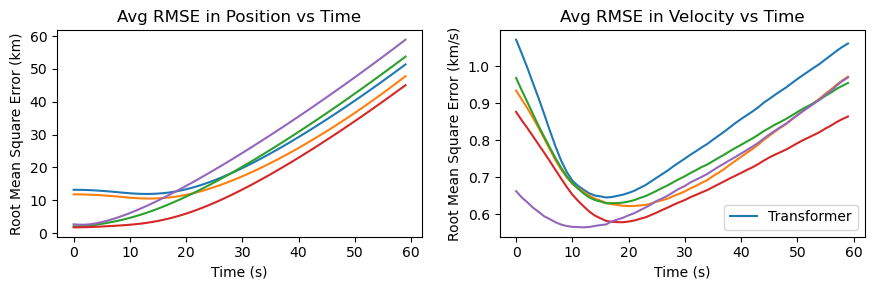

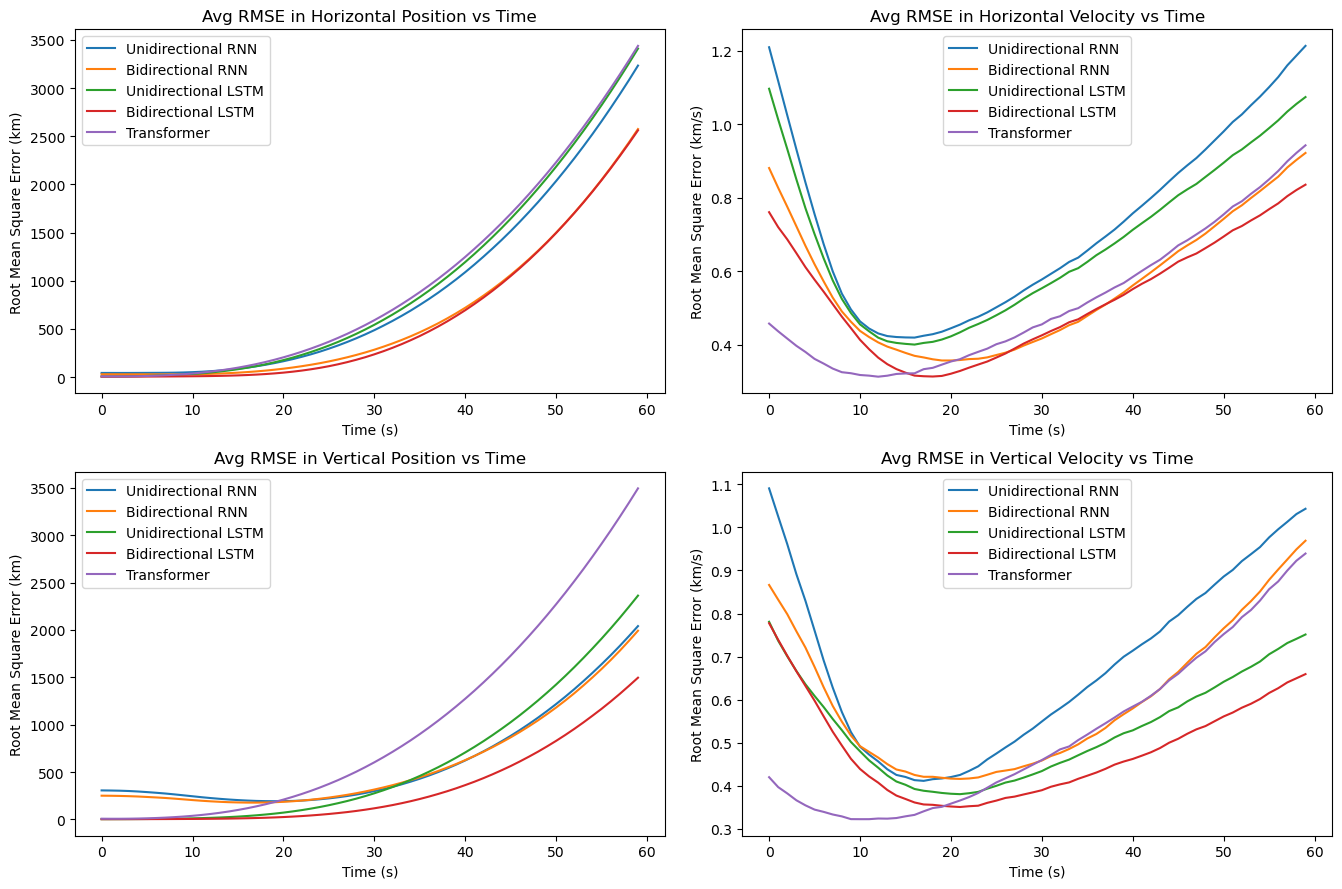

In [11]:
plotter = plotter()
mse_list = [UniRNN_testing_MSE, BiRNN_testing_MSE, UniLSTM_testing_MSE, BiLSTM_testing_MSE, Transformer_testing_MSE]
legend_list = ['Unidirectional RNN', 'Bidirectional RNN', 'Unidirectional LSTM', 'Bidirectional LSTM', 'Transformer']
plotter.two_by_one_MSE_vs_time(mse_list, legend_list)
plotter.two_by_two_MSE_vs_time(mse_list, legend_list)

In [12]:
class track_simulator():
    def __init__(self, predictor, updater, dataloader, time_span):
        """
        Parameters
        ----------
        transition_model : :class:`~.Predictor`
            The Stone Soup predictor to be used.
        measurement_model : :class:`~.Predictor`
            The Updater to be used.
        """
        self.predictor = predictor
        self.updater = updater
        self.dataloader = dataloader
        self.time_span = time_span

    def initializer(self, time_stamp, labels):
        state_range_min = labels[0][0].cpu().numpy()
        state_range_max = labels[0][1].cpu().numpy()
        state_vector = StateVector(np.random.uniform(low=state_range_min, high=state_range_max))
        return GaussianState(state_vector = state_vector, covar = np.eye(4), timestamp=time_stamp)

    def _simulate_track(self, input, labels):
        track = Track()
        prior = self.initializer(self.time_span[0], labels)
        for i in range(inputs.shape[1]):
            measurement = Detection(state_vector=input[0,i].cpu().numpy(), timestamp = self.time_span[i])
            prediction = self.predictor.predict(prior, timestamp=measurement.timestamp)
            posterior = self.updater.update(SingleHypothesis(prediction, measurement))
            track.append(posterior)
            prior = track[-1]
        tk = np.array([e.state_vector for e in track]).squeeze().T
        tk = torch.tensor(tk.astype(dtype=np.float32),device = device)
        return tk.T

    def generate_MSE(self):
        avg_loss = nn.MSELoss()
        trajectory_MSE = nn.MSELoss(reduction='none')
        MSE = torch.zeros(1,tMax,4, device=device) # Make this auto detect it
        test_loss=0
        i = 0
        for j, data in enumerate(self.dataloader):
            inputs, labels = data
            outputs = self._simulate_track(inputs, labels)
            test_loss += avg_loss(outputs, labels.squeeze())
            MSE += trajectory_MSE(outputs, labels.squeeze())
            i += 1
        return test_loss / i, MSE.squeeze()/len(self.dataloader)

In [13]:
'''
predictor = ExtendedKalmanPredictor(transition_model)
updater = ExtendedKalmanUpdater(measurement_model)

track_simulator = track_simulator(predictor, updater, testloader, time_span)

EKF_epoch_loss, EKF_track = track_simulator.generate_MSE()

track_simulator.generate_MSE()

epoch_mse, EKF_MSE = track_simulator.generate_MSE()
'''

'\npredictor = ExtendedKalmanPredictor(transition_model)\nupdater = ExtendedKalmanUpdater(measurement_model)\n\ntrack_simulator = track_simulator(predictor, updater, testloader, time_span)\n\nEKF_epoch_loss, EKF_track = track_simulator.generate_MSE()\n\ntrack_simulator.generate_MSE()\n\nepoch_mse, EKF_MSE = track_simulator.generate_MSE()\n'

NameError: name 'EKF_MSE' is not defined

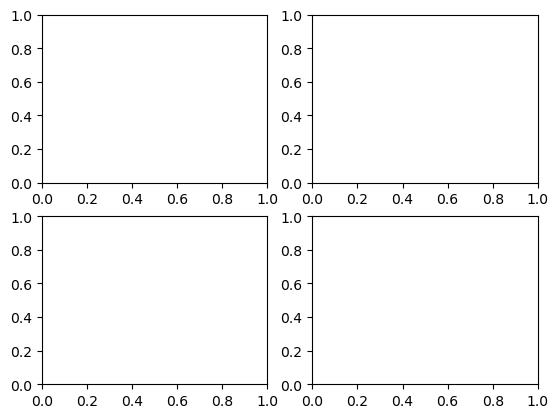

In [14]:
import matplotlib.pyplot as plt
fig, EKF_mse_plot = plt.subplots(2,2)

EKF_x = EKF_MSE.T[0].cpu().numpy()
EKF_xv = EKF_MSE.T[1].cpu().numpy()
EKF_y = EKF_MSE.T[2].cpu().numpy()
EKF_yv = EKF_MSE.T[3].cpu().numpy()
t = range(len(time_span))

fig.tight_layout()
EKF_mse_plot[0][0].plot(t, EKF_x, color="C0")
EKF_mse_plot[0][1].plot(t, EKF_xv, color="C1")
EKF_mse_plot[1][0].plot(t, EKF_y, color="C2")
EKF_mse_plot[1][1].plot(t, EKF_yv, color="C3")
#EKFmse[1].set_title("Testing Loss (MSE)")
